In [1]:
from qualibrate import QualibrationNode
from quam_libs.macros import T1_extraction
import numpy as np
import matplotlib.pyplot as plt


2026-02-20 15:01:56,025 - qm - INFO     - Starting session: 13c005ed-0ec0-4b30-9bb8-bb5c50542976


In [2]:
node  = QualibrationNode(name="quantum_memory_dephasing")

2026-02-20 15:02:06,390 - qualibrate - INFO - Creating node quantum_memory_dephasing


In [3]:
# plotting data structure

dephasing_T2_data = {
    'raw':{
        't2':[],
        't1':[],
        'dephasing_rate':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'mle':{
        't2':[],
        't1':[],
        'dephasing_rate':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'simulation_t2':{
        't2':[],
        'axes':{'original':[], 'fit':[]},
        'volume':{'original':[], 'fit':[]},
        'robustness':{'original':[], 'fit':[]},
    },
    'simulation_t2_detuning':{
    't2':[],
    'axes':{'original':[], 'fit':[]},
    'volume':{'original':[], 'fit':[]},
    'negativity':{'original':[], 'fit':[]},
    }
}

In [4]:
from pathlib import Path
data_path = Path('/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/data/Markovian')


In [5]:
# T1 and T2 data

T1_mean, T1_std, T2_mean, T2_std = [], [], [], []
T1_experiment_index = [1274,1283,1292,1301,1310,1319,1328,1337,1346,1355,1364,1381,1390,1399,1409,1418,1427,1445,1436,1454,1466]
T2_experiment_index = [1276,1285,1294,1303,1312,1321,1330,1339,1348,1357,1366,1383,1392,1401,1411,1420,1429,1447,1438,1456,1467]

for T1_index, T2_index in zip(T1_experiment_index, T2_experiment_index):
    node_T1_ds = node.load_from_id(T1_index, base_path=data_path).results['ds']
    mean, std = T1_extraction(node_T1_ds)
    T1_mean.append(mean)
    T1_std.append(std)
    
    node_T2 = node.load_from_id(T2_index, base_path=data_path)
    T2_mean.append(node_T2.results['fit_results']['q0']['decay'])
    T2_std.append(node_T2.results['fit_results']['q0']['decay_error'])


In [6]:
# ellipsoid data 
dephasing_experiment_index = [1497,1499,1500,1501,1502,1503,1504,1505,1506,1507,1508,1509,1510,1511,1512,1513,1514,1516,1515,1517,1518]
dephasing_voltage = [0,5,10,20,30,40,50,60,70,75,80,85,90,95,100,105,110,115,120,125,130]

dephasing_ds ={
    f'dephasing_voltage={dephasing_voltage[i]}mV':node.load_from_id(dephasing_experiment_index[i],base_path = data_path).results['ds']
    for i in range(len(dephasing_voltage))
}
dephasing_key = dephasing_ds.keys()

# dephasing vs flux amp

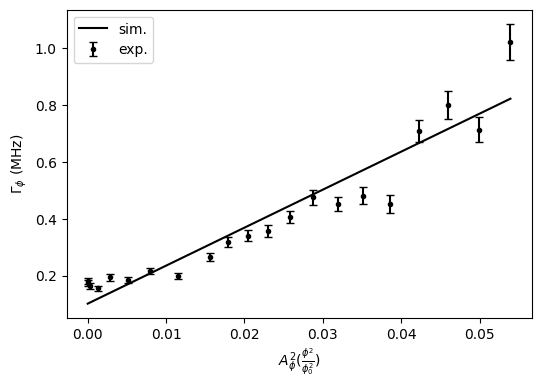

In [7]:
from quam_libs.macros import dephasing_errorbar
from scipy.optimize import curve_fit

gamma_phi,gamma_phi_std = dephasing_errorbar(np.array(T1_mean).reshape(-1),np.array(T2_mean),np.array(T1_std).reshape(-1),np.array(T2_std),pure=True)

fig = plt.figure(figsize=(6, 4))

phi_0 = 0.55978
xx = (np.array(dephasing_voltage)*1e-3/phi_0 )**2
a = -47701117184.95155

def fit_function(x,A):
    return (-0.5*phi_0*a*x*1e-3)*1e-6 +A

pop,povt = curve_fit(fit_function, xx, gamma_phi*1e-6, p0=[gamma_phi[0]])

plt.errorbar(xx, gamma_phi*1e-6, yerr=gamma_phi_std*1e-6, capsize=3,color='k',fmt='.', label='exp.')
#plt.plot(xx,(-0.5*phi_0*a*xx*1e-3+gamma_phi[0])*1e-6, label='sim.')
plt.plot(xx,fit_function(xx,pop[0]),color='k', label='sim.')

plt.xlabel(r'$A_\phi^2(\frac{\phi^2}{\phi_0^2})$')
plt.ylabel(r'$\Gamma_{\phi}$ (MHz)')
plt.legend()
plt.show()

# channel ellipsoid in dephasing noise

## experiment data

In [8]:
from quam_libs.QI_utils import bloch_vector_to_density_matrix
from quam_libs.analyzer import QuantumMemoryAnalyze, EllipsoidFitParameters

fit_params = EllipsoidFitParameters(
    filter_method="convex",      # "none" | "convex" | "ransac"
    correct_rotation_orientation =True,
    find_best_order=False
)

In [9]:
dephasing_data = {}
dephasing_analyze={}
do_convex_hull = True
for i, key in enumerate(dephasing_key):
    ds = dephasing_ds[key]
    data_xyz = np.array([[ds.Bloch_vector_x.values[0][i], ds.Bloch_vector_y.values[0][i], ds.Bloch_vector_z.values[0][i]] for i in range(len(ds.n_points.values))])
    data_angle = np.array([[ds.theta.values[i], ds.phi.values[i]] for i in range(len(ds.n_points.values))])
    data_dm = np.array([bloch_vector_to_density_matrix(data_xyz[i]) for i in range(len(data_xyz))])

    noise_analyzer = QuantumMemoryAnalyze(data_xyz,data_angle,fit_params)
    corrected_dm = noise_analyzer.corrected_dm
    corrected_bloch = noise_analyzer.corrected_bloch
    ellipsoid_results = noise_analyzer.ellipsoid_fit_results()
    dephasing_data[key] = {
        "qubit_properties":{
            "t1":T1_mean[i],
            "t1_std":T1_std[i],
            "t2":T2_mean[i],
            "t2_std":T2_std[i],
            "dephasing_rate":1/T2_mean[i] - 1/(2*T1_mean[i]),
        },
        'data':{
            'original_xyz': data_xyz,
            'original_dm' :data_dm,
            'angle': data_angle,
            'corrected_xyz': corrected_bloch,
            'corrected_dm': corrected_dm
        },
        'ellipsoid':{
            'axes':ellipsoid_results['axes'],
            'center':ellipsoid_results['center'],
            'volume':ellipsoid_results['volume'],
            'param':ellipsoid_results['fit_param'],
            "rotation_matrix":ellipsoid_results['rotation_matrix'],
        },
        "quantum_information":{
            "choi":noise_analyzer.choi,
            "robustness":noise_analyzer.memory_robustness
        }
    }
    dephasing_analyze[key] = noise_analyzer

In [10]:
robust  = [dephasing_data[key]['quantum_information']['robustness'] for key in dephasing_data.keys()]
T2 = [dephasing_data[key]['qubit_properties']['t2'] for key in dephasing_data.keys()]

In [11]:
for key in dephasing_data.keys():
    print(f"{key}, T2 = {dephasing_data[key]['qubit_properties']['t2']}, dephasing rate = {dephasing_data[key]['qubit_properties']['dephasing_rate']}")
    print(f"determinant = {np.linalg.det(dephasing_data[key]['ellipsoid']['rotation_matrix'])}")
    print(f"rotation matrxis = \n{dephasing_data[key]['ellipsoid']['rotation_matrix']}")
    print(f"axes = {dephasing_data[key]['ellipsoid']['axes']}")
    print(f"volume = {dephasing_data[key]['ellipsoid']['volume']}, robustness = {dephasing_data[key]['quantum_information']['robustness']}\n")
    

dephasing_voltage=0mV, T2 = 5.777260776577812e-06, dephasing rate = [173092.37377824]
determinant = -1.0
rotation matrxis = 
[[-0.71364824 -0.69546208 -0.08389684]
 [-0.69050793  0.67824002  0.25137478]
 [ 0.11791943 -0.2373246   0.96424688]]
axes = [0.72316099 0.68095996 0.77711545]
volume = 1.6029896414681508, robustness = 0.5645719387741708

dephasing_voltage=5mV, T2 = 5.521741138548081e-06, dephasing rate = [181102.25949249]
determinant = -1.0
rotation matrxis = 
[[-0.72664888 -0.6868923   0.01266354]
 [-0.67623753  0.71838565  0.16317124]
 [ 0.12117838 -0.11000464  0.98651649]]
axes = [0.746858   0.69532477 0.81914172]
volume = 1.7818592262424904, robustness = 0.6223920575351694

dephasing_voltage=10mV, T2 = 6.122530721714111e-06, dephasing rate = [163331.11400872]
determinant = -0.9999999999999998
rotation matrxis = 
[[ 0.66748128  0.74060149  0.07731865]
 [ 0.71924823 -0.61436946 -0.32439506]
 [ 0.19274525 -0.27213893  0.94275642]]
axes = [0.76177922 0.71275374 0.80379333]
volum

In [12]:
x_list = [dephasing_data[key]['qubit_properties']['dephasing_rate'] for key in dephasing_data.keys()]
#x_list = [dephasing_data[key]['qubit_properties']['T2'] for key in dephasing_data.keys()]

axes_list = [dephasing_data[key]['ellipsoid']['axes'] for key in dephasing_data.keys()]
volume_list = [dephasing_data[key]['ellipsoid']['volume'] for key in dephasing_data.keys()]
robust_list = [dephasing_data[key]['quantum_information']['robustness'] for key in dephasing_data.keys()]


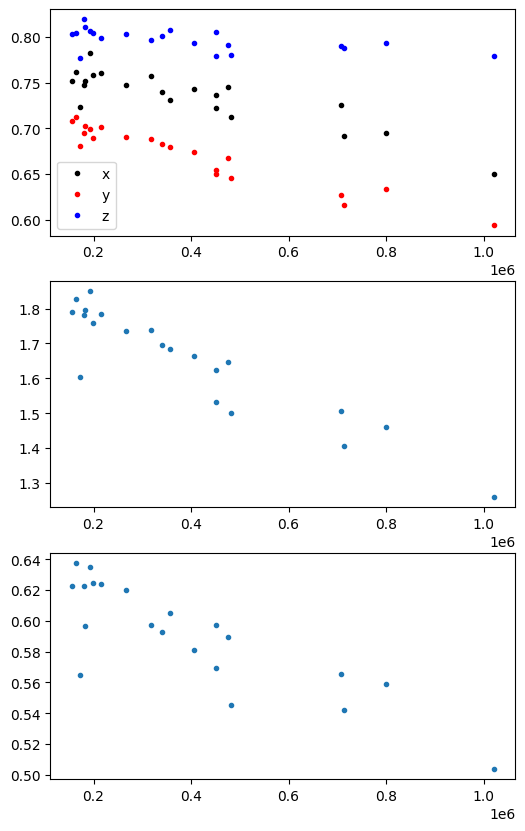

In [13]:
fig = plt.figure(figsize=(6,10))
ax_axes = fig.add_subplot(311)
ax_volume = fig.add_subplot(312)
ax_robustness = fig.add_subplot(313)
ax_axes.plot(x_list, [axes[0] for axes in axes_list], '.k',label='x')
ax_axes.plot(x_list, [axes[1] for axes in axes_list], '.r',label='y')
ax_axes.plot(x_list, [axes[2] for axes in axes_list], '.b',label='z')
ax_axes.legend()

ax_volume.plot(x_list, volume_list, '.')
ax_robustness.plot(x_list, robust_list, '.')
# ax_robustness.plot(x_list,find_best_order_list,'.')
# ax_robustness.set_xlim(0.1e6,0.4e6)

## simulation data

In [14]:
from quam_libs.QI_utils import density_matrix_to_bloch_vector, angle_to_density_matrix, BR_density_matrix
from quam_libs.quantum_channel_utils import error_gate
from quam_libs.macros import non_Gaussian_noise,generate_uniform_sphere_angles

error = 0.17
t_delay = 200e-9
t1 = 16e-6
T2_list = np.geomspace(np.min(T2_mean), np.max(T2_mean), num=21)
n_points = 1000
flux_noise = 0.002
data_angle_list = []

theta_range, phi_range = generate_uniform_sphere_angles(n_points)
for i in range(len(T2_list)):
    data_angle = []
    for j in range(len(theta_range)):
        data_angle.append([theta_range[j], phi_range[j]])
    data_angle_list.append(np.array(data_angle))

detuning =non_Gaussian_noise(flux_noise, N=n_points)-non_Gaussian_noise(0, N=n_points)
data_detuning_list = [detuning for i in range(len(T2_list))] # every n_points suffer different detuning across varying T2

simulation_data = {
    f"T2={round(T2_list[i]*1e6,3)}us": {
        'data_angle':data_angle_list[i].tolist(),
        'data_detuning':data_detuning_list[i].tolist()}
    for i in range(len(T2_list))
}
for j,key in enumerate(simulation_data.keys()):
    theta_list, phi_list = np.array(simulation_data[key]['data_angle'])[:,0],np.array(simulation_data[key]['data_angle'])[:,1]
    denstiy_state_list = []
    BR_density_state_list = []
    bloch_vector_list = []
    fidelity_list = []
    detuning_sum = 0
    for i in range(n_points):
        detuning_sum += data_detuning_list[j][i]
        denstiy_state_list.append(angle_to_density_matrix(theta_range[i], phi_range[i]))
        br_state = BR_density_matrix(theta_range[i], phi_range[i], t1, T2_list[j], t_delay,detuning=detuning_sum)
        error_br_state = error_gate(br_state,error)
        BR_density_state_list.append(error_br_state)
        bloch_vector_list.append(density_matrix_to_bloch_vector(BR_density_state_list[i]))
    simulation_data[key]['data_xyz'] = np.array(bloch_vector_list).tolist()


# old method

In [15]:
# old method - step 1: prepare data
from quam_libs.quantum_memory.legacy.NoiseAnalyze import NoiseAnalyze

sim_detuning_Noise_data = {}
sim_detuning_Noise_analyze={}
do_convex_hull = True
for i, key in enumerate(simulation_data):
    data_xyz = simulation_data[key]['data_xyz']
    data_angle = simulation_data[key]['data_angle']
    data_dm = np.array([bloch_vector_to_density_matrix(data_xyz[j]) for j in range(len(data_xyz))])
    sim_detuning_noise_analyzer = NoiseAnalyze(data_xyz,data_angle,ellipsoid_fit_parameters=fit_params)
    corrected_dm = sim_detuning_noise_analyzer.corrected_dm
    corrected_bloch = sim_detuning_noise_analyzer.corrected_bloch

    # Store basic data
    sim_detuning_Noise_data[key] = {
        'data_xyz': data_xyz,
        'data_dm' :data_dm,
        'data_angle': data_angle,
        'corrected_xyz': corrected_bloch,
        'corrected_dm': corrected_dm,
    }
    sim_detuning_Noise_analyze[key] = sim_detuning_noise_analyzer

/Users/jackchao/Desktop/Project/publication/quantum_memory/data_availability/quantum_memory_data/.venv/lib/python3.12/site-packages/pennylane/__init__.py:212: PennyLaneDeprecationWarning: PennyLane v0.44 has dropped maintainence support for NumPy < 2.0.0. You have version 1.26.4 installed. Future versions of PennyLane will not work with NumPy<2.0. Please consider upgrading NumPy using `python -m pip install numpy --upgrade`. 
  warnings.warn(


In [16]:
# Step 2: Add ellipsoid data and qubit properties
sim_detuning_Noise_data_with_ellipsoid = {}

for i, key in enumerate(sim_detuning_Noise_analyze.keys()):
    # Initialize the structure with data from step 1
    sim_detuning_Noise_data_with_ellipsoid[key] = {
        'data_xyz': sim_detuning_Noise_data[key]['data_xyz'],
        'data_dm': sim_detuning_Noise_data[key]['data_dm'],
        'data_angle': sim_detuning_Noise_data[key]['data_angle'],
        'corrected_xyz': sim_detuning_Noise_data[key]['corrected_xyz'],
        'corrected_dm': sim_detuning_Noise_data[key]['corrected_dm'],
    }
    
    # Extract T2 value from key (e.g., "T2=1.234us" -> 1.234e-6)
    t2_str = key.split('=')[1].split('us')[0]
    t2_value = float(t2_str) * 1e-6
    
    # Add qubit properties
    sim_detuning_Noise_data_with_ellipsoid[key]['qubit_properties'] = {
        't1': t1,
        't2': t2_value,
        'dephasing_rate': 1/t2_value - 1/(2*t1)
    }
    
    # Add placeholder ellipsoid structure (will be updated later)
    sim_detuning_Noise_data_with_ellipsoid[key]['ellipsoid'] = {
        'axes': None,
        'center': None,
        'volume': None,
        'rotation_matrix': None,
    }
    
    # Add placeholder quantum_information structure (will be updated later)
    sim_detuning_Noise_data_with_ellipsoid[key]['quantum_information'] = {
        'choi': None,
        'robustness': None,
        'negativity': None,
    }


In [17]:
from quam_libs.quantum_memory.legacy.marcos import dm_checker_dict
show_error = False
Noise_data_rm_index = {
    "corrected":dm_checker_dict(sim_detuning_Noise_data_with_ellipsoid, name ='corrected_dm' ,tolerance=1e-5, print_details=show_error),
    "data":dm_checker_dict(sim_detuning_Noise_data_with_ellipsoid, name ='data_dm' ,tolerance=1e-5, print_details=show_error)
}
for key in Noise_data_rm_index['data'].keys():
    if Noise_data_rm_index['data'][key] == [] and Noise_data_rm_index['corrected'][key] == []:
        pass
    else:
        print(Noise_data_rm_index['data'][key])
        print(Noise_data_rm_index['corrected'][key])

In [18]:
from quam_libs.quantum_memory.legacy.NoiseAnalyze import QuantumMemory

noise_result_dict ={}
negativity_list = []
robustness_list = []
for key in sim_detuning_Noise_analyze.keys():
    center, axes, R, volume, param = sim_detuning_Noise_analyze[key].ellipsoid_fit()
    qm_analyze = QuantumMemory(axes,center,R)
    negativity_list.append(qm_analyze.negativity)
    choi_state = qm_analyze.choi_state()
    robustness_list.append(qm_analyze.memory_robustness)
    noise_result_dict[key] ={
        'axes': axes,
        'center': center,
        'R': R,
        'volume': volume,
        'negativity': qm_analyze.negativity,
        'choi state': choi_state,
        'memory robustness': qm_analyze.memory_robustness
    }
    # Add quantum_information to sim_detuning_Noise_data_with_ellipsoid
    sim_detuning_Noise_data_with_ellipsoid[key]['quantum_information'] = {
        'choi': choi_state,
        'robustness': qm_analyze.memory_robustness
    }

In [19]:
def perm_order(axes,center,R_test,method='rotation'):
    if method == 'rotation':
        perm0 = np.argmax(np.abs(R_test[0]))
        perm1 = np.argmax(np.abs(R_test[1]))
        perm2 = np.argmax(np.abs(R_test[2]))
        perm = np.array([perm0, perm1, perm2])
        idx = np.argsort(perm)
    elif method == 'axes':
        z_max = np.argmax(np.abs(axes))
        if z_max == 0:
            idx = np.array([2,1,0])
        elif z_max == 1:
            idx = np.array([0,2,1])
        else:
            idx = np.array([0,1,2])
    R_test = R_test[idx, :]
    if np.linalg.det(R_test) < 0:
        pass
    elif np.linalg.det(R_test) > 0:
        R_test[0] *= -1  
    else:
        print(f"R_test is not a valid rotation matrix, det(R_test)={np.linalg.det(R_test)}")
        raise ValueError("R_test is not a valid rotation matrix")
    return axes,center,R_test,idx


keys= sim_detuning_Noise_analyze.keys()
for key in keys:
    print(f"Results for {key}:")
    R = noise_result_dict[key]['R']
    center = noise_result_dict[key]['center']
    axes = noise_result_dict[key]['axes']
    print(f"R for {key}:\n{R}")
    print(f"Center for {key}:\n{center}")
    print(f"Axes for {key}:\n{axes}")
    neg= QuantumMemory(axes,center,R).negativity
    print(f"Negativity for {key}: {neg}")
    print('-'*75)
    axes,center_,R,perm = perm_order(axes,center,R,method='axes')
    axes = axes[perm]
    center_ = center[perm]
    print(f"R for {key}:\n{R}")
    print(f"det(R) for {key}: \n{np.linalg.det(R)}")
    print(f"Center for {key}:\n{center}")
    print(f"Axes for {key}:\n{axes}")
    neg = QuantumMemory(axes,center,R).negativity
    print(f"Negativity for {key}: {neg}")
    print('-'*100)
    noise_result_dict[key]['R'] = R
    noise_result_dict[key]['axes'] = axes
    noise_result_dict[key]['center'] = center
    noise_result_dict[key]['negativity'] = neg
    
    # Update sim_detuning_Noise_data_with_ellipsoid with corrected ellipsoid data
    sim_detuning_Noise_data_with_ellipsoid[key]['ellipsoid']['axes'] = axes
    sim_detuning_Noise_data_with_ellipsoid[key]['ellipsoid']['center'] = center
    sim_detuning_Noise_data_with_ellipsoid[key]['ellipsoid']['rotation_matrix'] = R

Results for T2=0.979us:
R for T2=0.979us:
[[ 1.00000000e+00 -3.25138503e-04 -6.52081191e-17]
 [ 0.00000000e+00  6.71385531e-16  1.00000000e+00]
 [ 0.00000000e+00  1.00000005e+00 -4.25185966e-16]]
Center for T2=0.979us:
[ 5.63081530e-19 -6.86898655e-18  9.60650095e-03]
Axes for T2=0.979us:
[0.63038278 0.76372683 0.63038278]
Negativity for T2=0.979us: 0.2561404905854422
---------------------------------------------------------------------------
R for T2=0.979us:
[[-1.00000000e+00  3.25138503e-04  6.52081191e-17]
 [ 0.00000000e+00  1.00000005e+00 -4.25185966e-16]
 [ 0.00000000e+00  6.71385531e-16  1.00000000e+00]]
det(R) for T2=0.979us: 
-1.0000000528575215
Center for T2=0.979us:
[ 5.63081530e-19 -6.86898655e-18  9.60650095e-03]
Axes for T2=0.979us:
[0.63038278 0.63038278 0.76372683]
Negativity for T2=0.979us: 0.2561231098439588
----------------------------------------------------------------------------------------------------
Results for T2=1.075us:
R for T2=1.075us:
[[ 1.00000000e+00 -

In [20]:
from quam_libs.quantum_memory.legacy.marcos import diagnose_choi_states

tol = 1e-6
noise_choi_list = [noise_result_dict[key]["choi state"] for key in noise_result_dict.keys()]
keys = list(noise_result_dict.keys())
df = diagnose_choi_states(noise_choi_list,keys,tol_pos=tol, tol_tp=tol)
df

,index,λ_min,trace,TP dev,Hermitian_OK,CP_OK,TP_OK,all_OK
0,T2=0.979us,0.058726,1.0,0.004803,True,True,False,False
1,T2=1.075us,0.058675,1.0,0.004803,True,True,False,False
2,T2=1.182us,0.059030,1.0,0.004803,True,True,False,False
3,T2=1.298us,0.059068,1.0,0.004803,True,True,False,False
4,T2=1.427us,0.058560,1.0,0.004803,True,True,False,False
5,T2=1.568us,0.058491,1.0,0.004803,True,True,False,False
6,T2=1.723us,0.058472,1.0,0.004803,True,True,False,False
7,T2=1.893us,0.058324,1.0,0.004803,True,True,False,False
8,T2=2.08us,0.058347,1.0,0.004803,True,True,False,False
9,T2=2.286us,0.058270,1.0,0.004803,True,True,False,False


In [21]:
from quam_libs.quantum_memory.legacy.NoiseAnalyze import Checker
from quam_libs.quantum_memory.legacy.marcos import negativity_

np.set_printoptions(precision=3, suppress=True)
for i,key in enumerate(noise_result_dict.keys()):
    checker = Checker(noise_choi_list[i])
    choi, count = checker.choi_checker(index=[1], repeat=100, tol=tol, print_reason=False)
    new_negativity = negativity_(choi)
    print(f"After {count} iterations, the Choi state is:\n{choi}")
    print(f"Negativity for{key}: {negativity_(choi)}")
    print('-'*100)
    noise_result_dict[key]['negativity'] = new_negativity
    noise_result_dict[key]["choi state"] = choi
    
    # Update sim_detuning_Noise_data_with_ellipsoid with corrected choi state
    sim_detuning_Noise_data_with_ellipsoid[key]['quantum_information']['choi'] = choi

After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is:
[[ 0.252+0.j     0.   -0.174j  0.   -0.174j  0.158+0.j   ]
 [ 0.   +0.174j  0.248+0.j     0.158+0.j    -0.   +0.174j]
 [ 0.   +0.174j  0.158-0.j     0.252+0.j     0.   +0.174j]
 [ 0.158-0.j    -0.   -0.174j  0.   -0.174j  0.248+0.j   ]]
Negativity forT2=0.979us: 0.2561317385735613
----------------------------------------------------------------------------------------------------
After 2 iterations, the Choi state is valid.
After 2 iterations, the Choi state is:
[[ 0.252+0.j     0.   -0.176j  0.   -0.176j  0.161+0.001j]
 [ 0.   +0.176j  0.248+0.j     0.161+0.j    -0.   +0.176j]
 [ 0.   +0.176j  0.161-0.j     0.252+0.j     0.   +0.176j]
 [ 0.161-0.001j -0.   -0.176j  0.   -0.176j  0.248+0.j   ]]
Negativity forT2=1.075us: 0.26198462847161186
----------------------------------------------------------------------------------------------------
After 2 iterations, the Choi state is valid.
After 2 iterations, 

In [22]:
noise_choi_list = [noise_result_dict[key]["choi state"] for key in noise_result_dict.keys()]
keys = list(noise_result_dict.keys())
df = diagnose_choi_states(noise_choi_list,keys,tol_pos=tol, tol_tp=tol)
df

,index,λ_min,trace,TP dev,Hermitian_OK,CP_OK,TP_OK,all_OK
0,T2=0.979us,0.058896,1.0,1.793080e-09,True,True,True,True
1,T2=1.075us,0.058861,1.0,1.871174e-09,True,True,True,True
2,T2=1.182us,0.056667,1.0,1.219006e-09,True,True,True,True
3,T2=1.298us,0.056667,1.0,1.283746e-09,True,True,True,True
4,T2=1.427us,0.058804,1.0,2.068603e-09,True,True,True,True
5,T2=1.568us,0.058758,1.0,2.123716e-09,True,True,True,True
6,T2=1.723us,0.058765,1.0,2.173979e-09,True,True,True,True
7,T2=1.893us,0.058642,1.0,2.220206e-09,True,True,True,True
8,T2=2.08us,0.058699,1.0,2.238150e-09,True,True,True,True
9,T2=2.286us,0.058655,1.0,2.212249e-09,True,True,True,True


In [23]:
from quam_libs.quantum_memory.entanglement_robustness import entanglementRobustness
for key in noise_result_dict.keys():
    noise_result_dict[key]['memory robustness'] = entanglementRobustness(noise_result_dict[key]['choi state'])
    
    # Update sim_detuning_Noise_data_with_ellipsoid with robustness
    sim_detuning_Noise_data_with_ellipsoid[key]['quantum_information']['robustness'] = entanglementRobustness(noise_result_dict[key]['choi state'])

Text(0.5, 0, 'T2(us)')

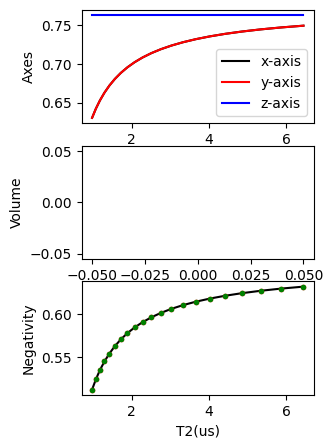

In [24]:
axes_list = np.array([sim_detuning_Noise_data_with_ellipsoid[key]['ellipsoid']['axes'] for key in sim_detuning_Noise_analyze.keys()])
volume_list = np.array([sim_detuning_Noise_data_with_ellipsoid[key]['ellipsoid']['volume'] for key in sim_detuning_Noise_analyze.keys()])
negativity_list = np.array([sim_detuning_Noise_data_with_ellipsoid[key]['quantum_information'].get('negativity', noise_result_dict[key]['negativity']) for key in sim_detuning_Noise_analyze.keys()])*2
robustness_list = np.array([sim_detuning_Noise_data_with_ellipsoid[key]['quantum_information']['robustness'] for key in sim_detuning_Noise_analyze.keys()])
fig = plt.figure(figsize=(3, 5))
ax_name = ['axes', 'volume', 'negativity']
ax_axes = fig.add_subplot(len(ax_name), 1, 1)
ax_volume = fig.add_subplot(len(ax_name), 1, 2)
ax_negativity = fig.add_subplot(len(ax_name), 1, 3)
#ax_axes.set_title('simulation T2 and detuning = 5MHz')
ax_axes.plot(T2_list*1e6,axes_list[:, 0],'k' ,label='x-axis')
ax_axes.plot(T2_list*1e6,axes_list[:, 1],'r',label='y-axis')
ax_axes.plot(T2_list*1e6,axes_list[:, 2],'b', label='z-axis')
ax_axes.legend()
ax_axes.set_ylabel('Axes')
ax_volume.plot(T2_list*1e6,volume_list,'k', label='volume')
ax_volume.plot(T2_list*1e6,volume_list,'.r', label='volume')

ax_volume.set_ylabel('Volume')
ax_negativity.plot(T2_list*1e6,negativity_list,'k' ,label='negativity')
ax_negativity.plot(T2_list*1e6,negativity_list,'.r',label='negativity')
ax_negativity.plot(T2_list*1e6,robustness_list,'.g',label='memory robustness')
ax_negativity.set_ylabel('Negativity')
ax_negativity.set_xlabel('T2(us)')

# plot togather

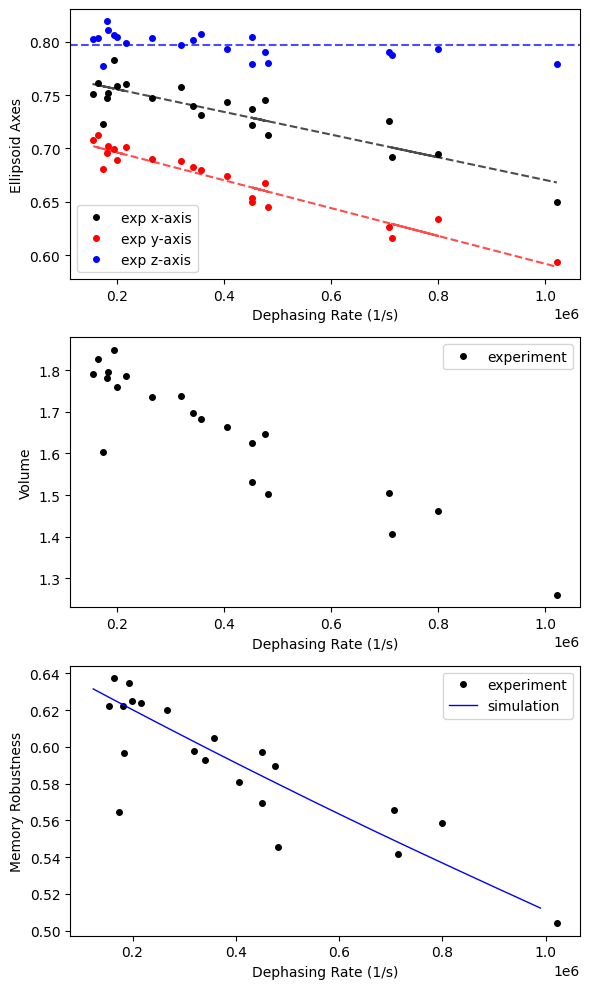

In [25]:
# Plot simulation and experiment data together: axes, volume and robustness vs dephasing_rate

# Prepare experiment data
exp_dephasing_rates = np.array([dephasing_data[key]['qubit_properties']['dephasing_rate'] for key in dephasing_data.keys()])
exp_axes_list = np.array([dephasing_data[key]['ellipsoid']['axes'] for key in dephasing_data.keys()])
exp_volume_list = np.array([dephasing_data[key]['ellipsoid']['volume'] for key in dephasing_data.keys()])
exp_robustness_list = np.array([dephasing_data[key]['quantum_information']['robustness'] for key in dephasing_data.keys()])

# Prepare simulation data - calculate dephasing_rate from T1 and T2 if not present
sim_dephasing_rates = []
sim_axes_list = []
sim_robustness_list = []

for key in sim_detuning_Noise_data_with_ellipsoid.keys():
    # Get dephasing_rate from qubit_properties or calculate if missing
    if 'dephasing_rate' in sim_detuning_Noise_data_with_ellipsoid[key]['qubit_properties']:
        sim_dephasing_rates.append(sim_detuning_Noise_data_with_ellipsoid[key]['qubit_properties']['dephasing_rate'])
    else:
        # Calculate if not present
        t2_sim = sim_detuning_Noise_data_with_ellipsoid[key]['qubit_properties']['t2']
        t1_sim = sim_detuning_Noise_data_with_ellipsoid[key]['qubit_properties']['t1']
        sim_dephasing_rates.append(1/t2_sim - 1/(2*t1_sim))
    
    sim_axes_list.append(sim_detuning_Noise_data_with_ellipsoid[key]['ellipsoid']['axes'])
    sim_robustness_list.append(sim_detuning_Noise_data_with_ellipsoid[key]['quantum_information']['robustness'])

sim_dephasing_rates = np.array(sim_dephasing_rates)
sim_axes_list = np.array(sim_axes_list)
sim_robustness_list = np.array(sim_robustness_list)

# Create figure with 3 subplots
fig, (ax_axes_comp, ax_volume_comp, ax_robust_comp) = plt.subplots(3, 1, figsize=(6, 10))

# Plot 1: Axes comparison with fitting
ax_axes_comp.plot(exp_dephasing_rates, exp_axes_list[:, 0], 'ko', label='exp x-axis', markersize=4)
ax_axes_comp.plot(exp_dephasing_rates, exp_axes_list[:, 1], 'ro', label='exp y-axis', markersize=4)
ax_axes_comp.plot(exp_dephasing_rates, exp_axes_list[:, 2], 'bo', label='exp z-axis', markersize=4)

# Fitting for axes using polyfit (linear fitting with degree 1)
# Ensure 1D arrays
x_fit = np.asarray(exp_dephasing_rates).flatten()

# X-axis: linear fitting
coeffs_x = np.polyfit(x_fit, exp_axes_list[:, 0], 1)
fit_x = np.polyval(coeffs_x, x_fit)
ax_axes_comp.plot(x_fit, fit_x, 'k--', alpha=0.7, linewidth=1.5)

# Y-axis: linear fitting
coeffs_y = np.polyfit(x_fit, exp_axes_list[:, 1], 1)
fit_y = np.polyval(coeffs_y, x_fit)
ax_axes_comp.plot(x_fit, fit_y, 'r--', alpha=0.7, linewidth=1.5)

# Z-axis: horizontal line (average)
z_mean = np.mean(exp_axes_list[:, 2])
ax_axes_comp.axhline(y=z_mean, color='b', linestyle='--', alpha=0.7, linewidth=1.5)
ax_axes_comp.set_xlabel('Dephasing Rate (1/s)')
ax_axes_comp.set_ylabel('Ellipsoid Axes')
ax_axes_comp.legend()

# Plot 2: Volume comparison
ax_volume_comp.plot(exp_dephasing_rates, exp_volume_list, 'ko', label='experiment', markersize=4, linewidth=1)
ax_volume_comp.set_xlabel('Dephasing Rate (1/s)')
ax_volume_comp.set_ylabel('Volume')
ax_volume_comp.legend()

# Plot 3: Robustness comparison
ax_robust_comp.plot(exp_dephasing_rates, exp_robustness_list, 'ko', label='experiment', markersize=4, linewidth=1)
ax_robust_comp.plot(sim_dephasing_rates, sim_robustness_list, 'b-', label='simulation', linewidth=1)
ax_robust_comp.set_xlabel('Dephasing Rate (1/s)')
ax_robust_comp.set_ylabel('Memory Robustness')
ax_robust_comp.legend()

plt.tight_layout()
plt.show()